## Coding session part 1 : introduction to explainability and interpretability 

The goal of this coding session is to understand the fundamentals of applied explainability and interpretability. We will focus on simple principles such as how to interpret a basic model, how to use a database to make explanations more relevant. At the end of this session you should be able to : 
1. Interpret the coefficients of a linear regression globally and locally
2. Interpret a decision tree model globally and locally 
3. Code and interpret an partial dependence plot 
4. Code a simple version of LIME  

In [5]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn import tree as tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# import pydotplus
# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()

## Loading a toy dataset + one hot encoder

In [6]:
# Load data 
categorical_features = [
    'sex', 'marital_status',
    'relationship', #'education'
]
feature_names = [
    'age', 'education_num', # 'education',
    'marital_status',
    'relationship', 'sex', 'hours_per_week',
]

data = pd.read_csv("./adult.csv")
data.drop('fnlwgt', axis=1, inplace=True)
data.drop('race', axis=1, inplace=True)
# preprocess
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)
data.replace(
    ['Divorced', 'Married-AF-spouse',
     'Married-civ-spouse', 'Married-spouse-absent',
     'Never-married', 'Separated', 'Widowed'],
    ['divorced', 'married', 'married', 'married',
     'not married', 'not married', 'not married'], 
    inplace=True)
data.reset_index(drop=True, inplace=True)
data['Income'] = data['Income'].apply(lambda x: x.replace('.', ''))
del data['occupation'], data['workclass']

# format output variable as a 0/1 output
data['Income'] = (data['Income'] == '>50K').astype(int)
x, y = data[feature_names], data['Income']

# encoding categorical features 
non_cate_features = [x for x in feature_names if x not in categorical_features]
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
one_hot_encoder = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)],
    remainder='passthrough',
    sparse_threshold=0,
)
one_hot_encoder.fit(x)
x_encoded = one_hot_encoder.transform(x)
cate_fnames = one_hot_encoder.transformers_[0][1]['onehot'].get_feature_names()
# put column name in the encoded feature name
cate_fname_full = [categorical_features[int(f.split('_')[0][1:])] + '__is__' + f[3:] for f in cate_fnames]
non_cate_features = [x for x in feature_names if x not in categorical_features]
col_names = list(cate_fname_full) + list(non_cate_features)
encoded_samples = pd.DataFrame(data=x_encoded, columns=col_names)
encoded_feature_names = encoded_samples.columns
# encoded_names_dict = {
#     k: list(filter(lambda x: x.split('__')[0] == k, encoded_feature_names))
#     for k in feature_names
# }

## 1. Interpret a linear model 

### 1.1 Global interpretation  

Steps : 
1. Train a linear regression model (Lasso) categorize the output value with a threshold (don't spend too much time on accuracy) 
2. Display the coefficients of the linear model (ideally with a sorted horizontal bar plot)
3. Interpret the coefficient values 
  - how data normalization impacts the value of the coefficient ? 
  - what is the correct normalization that one would expect ? why ? 

In [7]:
from sklearn.preprocessing import StandardScaler

# train a linear model (Lasso) on the adult data
# you will use a threshold on the output variable to categorize it 
scaler = StandardScaler()

x_hat = scaler.fit_transform(X=encoded_samples)

X_train, X_test, y_train, y_test = train_test_split(x_hat, y, test_size=.33)

from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.01)
reg.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, reg.predict(X_test) > 0.5))

Accuracy score (test dataset):  0.8168051460734388


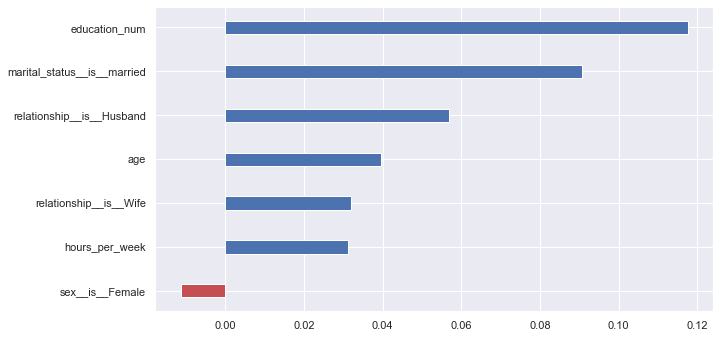

In [8]:
imp_dict = {k: v for k, v in zip(col_names, reg.coef_) if abs(v) > 10**-12}

imp_dict = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: abs(item[1]))}
plt.rcParams.update({'font.size': 21})
fig = plt.figure(figsize=(10, len(imp_dict) * .8))
y_pos = np.arange(len(imp_dict))
clrs = ['b' if val>=0 else 'r' for val in imp_dict.values()]
plot = plt.barh(y_pos, list(imp_dict.values()), align='center', height=0.3, color=clrs)
ticks = plt.yticks(y_pos, tuple(imp_dict.keys()))

### 1.2 Local interpretation 

Using the same linear model, provide a local explanation of the output for specific samples. 

Steps : 
1. randomly select one sample among encoded_samples
2. compute the difference with the population average
3. apply model coefficients to these differences 
4. interpret the restults 

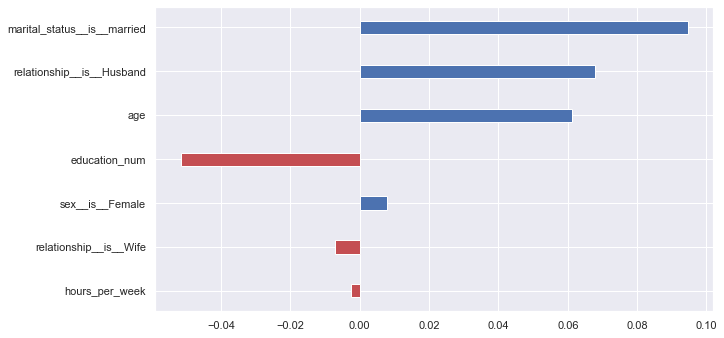

In [9]:
rdn_sample = x_hat[np.random.randint(len(x_hat))]
feature_diff = rdn_sample - np.mean(x_hat)
fi = {key: v1 * v2 for key, v1, v2 in zip(col_names, reg.coef_, feature_diff)}
imp_dict = {k: v for k, v in sorted(fi.items(), key=lambda item: abs(item[1])) if abs(v) > 10**-12}
plt.rcParams.update({'font.size': 21})
fig = plt.figure(figsize=(10, len(imp_dict) * .8))
y_pos = np.arange(len(imp_dict))
clrs = ['b' if val>=0 else 'r' for val in imp_dict.values()]
plot = plt.barh(y_pos, list(imp_dict.values()), align='center', height=0.3, color=clrs)
ticks = plt.yticks(y_pos, tuple(imp_dict.keys()))

## 2. Interpret a decision tree classifier 

In [10]:
# Train random forest 
X_train, X_test, y_train, y_test = train_test_split(encoded_samples, y, test_size=.33)
dt = DecisionTreeClassifier(max_leaf_nodes=20)
dt.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, dt.predict(X_test)))

Accuracy score (test dataset):  0.8208255159474672


### 2.1 Global interpretation 

Display the decision tree classifier and interpret it 

In [20]:
from sklearn import tree as tree
import pydotplus
import graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


dot_data = tree.export_graphviz(dt, 
                  feature_names=encoded_feature_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

### 2.2 Local interpretation 

How could you use the model drawing to interpret locally one output ?

## 3. Partial dependence plot 

Draw the partial dependence plot of the decision tree model dt trained above. 

Following this morning typology of XAI method (global/local, black-box/white-box), how can be classified the PDP? 

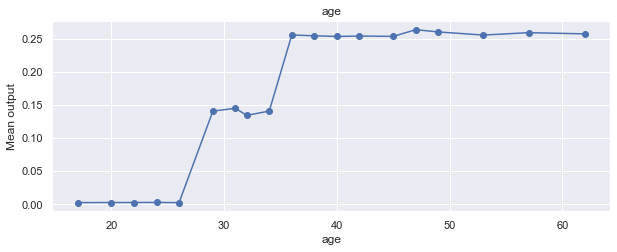

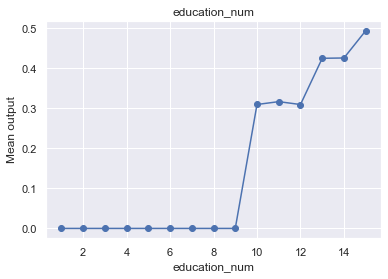

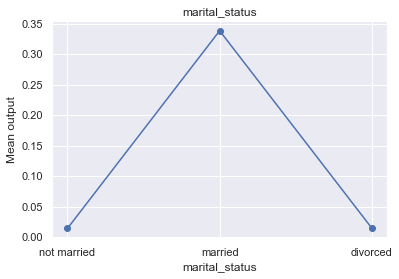

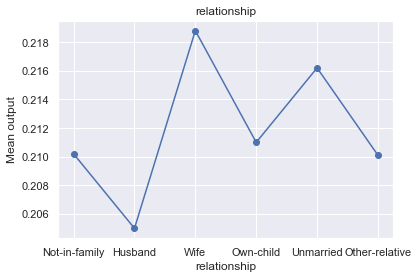

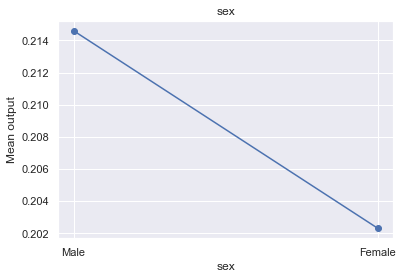

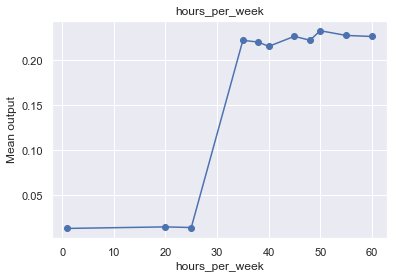

In [224]:
def replace_fixed_col_fixed_values(data, model, col_val_dict, size=10000, ):
    """
    Sampling for Partial Dependance Plot.
    Change every value of a column of the population to a specific value

    :param base: Base XAI
    :param col_val_dict: dictionary with column name as key and fix value as value
    :param actionable_features: actionable features
    :return: dataframe of PDP samples
    """
    new_val_df = data.sample(1) # get one sample to have the format of the dataframe
    for k, v in col_val_dict.items(): # use column value dictionnary
        new_val_df.loc[:, k] = v
    samples = data.copy()
    samples = samples.sample(size, replace=True)
    for k, v in col_val_dict.items():
        samples[k] = v
    samples['output'] = model.predict(one_hot_encoder.transform(samples))
    return samples

def partial_dependance(data, model, feature_names, nbins=20):
    """
    Compute data for the partial dependance plot.
    """
    res = {}
    for i, col in enumerate(feature_names):
        col_values_list = []
        if data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            bins_pdp = []
            if data[col].nunique() < nbins:
                bins_pdp = data[col].unique()
            else:
                for q in np.linspace(0, 1, nbins):
                    bins_pdp.append(data[col].quantile(q))
            bins_pdp = sorted(list(set(bins_pdp)))
            hist_value = np.histogram(data[col], bins=bins_pdp)[0]
        # not numeric types
        else:
            bins_pdp = data[col].unique()
            hist_value = data[col].value_counts()[bins_pdp].values
        for val, size in zip(bins_pdp, hist_value):
            mean_output_value = replace_fixed_col_fixed_values(data, model, col_val_dict={col: val})['output'].mean()
            col_values_list.append({'x': val, 'y': mean_output_value, 'size': size})
        res[col] = col_values_list
    return {k: v for k, v in res.items() if k in feature_names}

def plot_partial_dependance(output_pdp):
    fig = plt.figure(figsize=(10, 3.5))
    for var, values in output_pdp.items():
        plt.plot([v['x'] for v in values], [v['y'] for v in values], 'o-')
        plt.xlabel(var)
        plt.ylabel("Mean output")
        plt.title(var)
        plt.show()

plot_partial_dependance(partial_dependance(x, dt, feature_names, nbins=20))

## 4.  Local Interpretable Model-agnostic Explanations (LIME)

LIME is a popular explanation method discovered in 2016 by Marco Tulio Ribeiro. 

"An essential criterion for explanation is **local fidelity**. Although it is often impossible for an explanation to be completely faithful unless it is the complete description of the model itself, for an explanation to be meaningful it must at least be locally faithful, i.e. it must correspond to how the model behaves in the vicinity of the instance being predicted. We note that local fidelity does not imply global fidelity: features that are globally important may not be important in the local context, and vice versa. While global fidelity would imply local fidelity, identifying globally faithful explanations that are interpretable remains a challenge for complex models. 

An explainer should be able to explain any model, and thus be **model-agnostic** (i.e. treat the original model as a black box). Apart from the fact that many state-of-the-art classifiers are not currently interpretable, this also provides flexibility to explain future classifiers."

Original paper is available here: https://arxiv.org/pdf/1602.04938.pdf (recommended). 

According to this extract how should be classified LIME in the typology of explanation method? 

### 4.1 Step 1: sampling around an instance 

The first step toward a LIME-like explainer is to create a function capable of creating samples in the vicinity of any instance for the x space (data point). 

While there are several ways of acheiving this objective, we will focus today on the simplest one : random perturbation according to a gaussian distribution. Starting from an instance $X_{poe}$, point-of-interest, that we wish to explain, we create a dataset of the form $X_{poe} + \epsilon$ where $\epsilon \sim N(0, \sigma)$. Note that this approach only works with numerical data. 

Train a decision tree with only numerical features, it will play the role of our black-box model to be explained

In [226]:
numerical_data = [x for x in feature_names if x not in categorical_features]

# Train random forest 
X_train, X_test, y_train, y_test = train_test_split(data[numerical_data], y, test_size=.33)
dt = DecisionTreeClassifier(max_leaf_nodes=20)
dt.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, dt.predict(X_test)))

Accuracy score (test dataset):  0.7981774323237738


Create a function that takes as argument $X_{poe}$ and that return a dataset containing k $X_{poe} + \epsilon$ where $\epsilon \sim N(0, \sigma)$ elements. 

In [242]:
dataset = data[numerical_data]
x_poe = dataset.sample(1)
k = 1000
sigma = dataset.std().values / 2.

def gaussian_sampling(x_poe, dataset, k, sigma):
    return np.random.normal(x_poe, sigma, size=(k, len(sigma)))

x_poe_samples = gaussian_sampling(x_poe, dataset, k, sigma)

### Step 2: train an interpretable classifier on these samples 

The second step to obtain a LIME-like classifier is to train an interpretable model on these samples. Although the black-box model may be globally very complex on the entire feature space, we can assume that it can be approximated locally with a very simple model. Then this simple model will inform us on the most significative features in the vicinity of $X_{poe}$. 

Today, for the sake of simplicity, we will us a linear model (Lasso) as our interpretable model. 

Train a linear regression on the samples and interpret the coefficient to have a local explanation. You may use results of the part 1 to help you. 

In [246]:
from sklearn.preprocessing import StandardScaler

# train a linear model (Lasso) on the adult data
# you will use a threshold on the output variable to categorize it 
scaler = StandardScaler()

x_hat = scaler.fit_transform(X=x_poe_samples)
y = dt.predict(x_poe_samples)

X_train, X_test, y_train, y_test = train_test_split(x_hat, y, test_size=.33)

from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.0001)
reg.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, reg.predict(X_test) > 0.5))

Accuracy score (test dataset):  0.9939393939393939


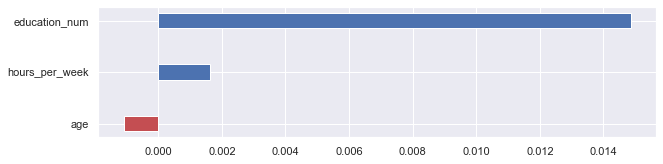

In [247]:
fi = {key: v for key, v in zip(numerical_data, reg.coef_)}
imp_dict = {k: v for k, v in sorted(fi.items(), key=lambda item: abs(item[1])) if abs(v) > 10**-12}
plt.rcParams.update({'font.size': 21})
fig = plt.figure(figsize=(10, len(imp_dict) * .8))
y_pos = np.arange(len(imp_dict))
clrs = ['b' if val>=0 else 'r' for val in imp_dict.values()]
plot = plt.barh(y_pos, list(imp_dict.values()), align='center', height=0.3, color=clrs)
ticks = plt.yticks(y_pos, tuple(imp_dict.keys()))

Questions : 
  - how you would interpret this explanation? 
  - what are the effects of the parameters k, sigma and alpha on the final explanation? 

Bonus : 
  - find alternative ways of sampling in the vicinity of $X_{poe}$ and explain the differences with gaussian_sampling 
  - find alternative interpretable models 
  - create a datavizualization of the sampling and intertable model steps 